# Box Office Predictions

Applied machine learning project to predict the profitability of a movie before it's released.

## Objectives

- In general, is the **profit** of a movie correlated with its user **score** on IMDb? How about its number of **votes**? What do these correlations tell you?
- Using the data from 2014 and earlier, can you predict the **profit** of movies released in 2015 and 2016? Tip: You should only use information that would be available BEFORE a movie is released (i.e. no information on user score, number of votes, or gross revenues).
- Let's say that you were able to show movies pre-release to a representative focus group, which accurately anticipates the **score** of a movie (but not its overall popularity), can you improve your model?

## Machine Learning Task

- Apply supervised learning regression techniques to learn patterns in 2014 and earlier movies to predict the **profit** of a movies released in 2015 and 2016
- Only use inputs that would be available before the movie's release
- Win condition: not specified

In [1]:
# Module imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Import model and metrics
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Import Pipeline
from sklearn.pipeline import Pipeline

# Import preprocessing and grid search cross validation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [2]:
# Import data
df = pd.read_csv('box_office_predictions.csv')

df.head()

,budget,country,director,genre,gross,name,rating,runtime,score,star,studio,votes
0,237000000.0,UK,James Cameron,Action,760507625.0,Avatar (2009),PG-13,162,7.8,Sam Worthington,Twentieth Century Fox Film Corporation,958400
1,200000000.0,USA,James Cameron,Drama,658672302.0,Titanic (1997),PG-13,194,7.8,Leonardo DiCaprio,Twentieth Century Fox Film Corporation,865551
2,150000000.0,USA,Colin Trevorrow,Action,652270625.0,Jurassic World (2015),PG-13,124,7.0,Chris Pratt,Universal Pictures,470625
3,220000000.0,USA,Joss Whedon,Action,623357910.0,The Avengers (2012),PG-13,143,8.1,Robert Downey Jr.,Marvel Studios,1069292
4,185000000.0,USA,Christopher Nolan,Action,534858444.0,The Dark Knight (2008),PG-13,152,9.0,Christian Bale,Warner Bros.,1845853


In [3]:
# Write data to a .tsv file to import into SQL challenges
# df.to_csv('~/MySQLData/BoxOffice.tsv', sep='\t', header=False, index=False)

In [11]:
# Find longest string in each column
#    For SQL challenges to figure out type of each column
# for col in df.dtypes[df.dtypes == 'object'].index:
#     print(col)
#     print('Longest string length: {}'.format(df[col].str.len().max()))
#     print()

In [51]:
# Add 'profit' column
df['profit'] = df['gross'] - df['budget']

# Split release year from name and create a film age feature
df['age'] = 2014 - df['name'].str[-5:-1].astype(int)

df.head()

,budget,country,director,genre,gross,name,rating,runtime,score,star,studio,votes,profit,age
0,237000000.0,UK,James Cameron,Action,760507625.0,Avatar (2009),PG-13,162,7.8,Sam Worthington,Twentieth Century Fox Film Corporation,958400,523507625.0,5
1,200000000.0,USA,James Cameron,Drama,658672302.0,Titanic (1997),PG-13,194,7.8,Leonardo DiCaprio,Twentieth Century Fox Film Corporation,865551,458672302.0,17
2,150000000.0,USA,Colin Trevorrow,Action,652270625.0,Jurassic World (2015),PG-13,124,7.0,Chris Pratt,Universal Pictures,470625,502270625.0,-1
3,220000000.0,USA,Joss Whedon,Action,623357910.0,The Avengers (2012),PG-13,143,8.1,Robert Downey Jr.,Marvel Studios,1069292,403357910.0,2
4,185000000.0,USA,Christopher Nolan,Action,534858444.0,The Dark Knight (2008),PG-13,152,9.0,Christian Bale,Warner Bros.,1845853,349858444.0,6


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 14 columns):
budget      6000 non-null float64
country     6000 non-null object
director    6000 non-null object
genre       6000 non-null object
gross       6000 non-null float64
name        6000 non-null object
rating      6000 non-null object
runtime     6000 non-null int64
score       6000 non-null float64
star        6000 non-null object
studio      6000 non-null object
votes       6000 non-null int64
profit      6000 non-null float64
age         6000 non-null int64
dtypes: float64(4), int64(3), object(7)
memory usage: 656.3+ KB


In [53]:
df.describe()

,budget,gross,runtime,score,votes,profit,age
count,6.000000e+03,6.000000e+03,6000.000000,6000.000000,6.000000e+03,6.000000e+03,6000.000000
mean,2.469918e+07,3.341635e+07,106.587000,6.386383,7.188537e+04,8.717169e+06,12.972833
std,3.721710e+07,5.735205e+07,18.026885,0.994921,1.308033e+05,4.017804e+07,8.960998
min,0.000000e+00,4.410000e+02,50.000000,1.500000,2.700000e+01,-1.769219e+08,-2.000000
25%,0.000000e+00,1.527796e+06,95.000000,5.800000,7.791750e+03,-5.121963e+06,5.000000
50%,1.100000e+07,1.229897e+07,102.000000,6.500000,2.660150e+04,9.602125e+05,13.000000
75%,3.262500e+07,4.007256e+07,115.000000,7.100000,7.677475e+04,1.401508e+07,21.000000
max,3.000000e+08,7.605076e+08,366.000000,9.300000,1.868308e+06,5.235076e+08,28.000000


No obvious missing values after running the `info()` method, but the `budget` minimum of zero indicates otherwise.

In [54]:
# Remove films where the budget is 0
df = df.loc[df.budget > 0,:]

In [55]:
# See unique values in categorical columns
for col in df.dtypes[df.dtypes == 'object'].index:
    print(col)
    print('Unique Values: {}'.format(df[col].nunique()))
    print()

country
Unique Values: 42

director
Unique Values: 1757

genre
Unique Values: 16

name
Unique Values: 4089

rating
Unique Values: 8

star
Unique Values: 1501

studio
Unique Values: 1232



A lot of unique values for several categories indicates sparse classes, which can lead to overfitting. Some of the values will need to be combined to reduce the feature space.

In [56]:
# Sort unique values 
for col in df.dtypes[df.dtypes == 'object'].index:
    print(col)
    print(df[col].value_counts().head())
    print()

country
USA        3275
UK          323
France       98
Germany      81
Canada       69
Name: country, dtype: int64

director
Woody Allen          26
Clint Eastwood       20
Steven Spielberg     20
Ron Howard           19
Steven Soderbergh    18
Name: director, dtype: int64

genre
Comedy       1136
Action        972
Drama         719
Crime         315
Adventure     253
Name: genre, dtype: int64

name
The Grass Harp (1995)    1
Psycho (1998)            1
Fiza (2000)              1
Ella Enchanted (2004)    1
Cinderella (2015)        1
Name: name, dtype: int64

rating
R            2001
PG-13        1372
PG            562
G              90
NOT RATED      36
Name: rating, dtype: int64

star
Nicolas Cage      36
Robert De Niro    29
Bruce Willis      28
Tom Hanks         26
Adam Sandler      26
Name: star, dtype: int64

studio
Universal Pictures                        235
Warner Bros.                              231
Paramount Pictures                        197
Twentieth Century Fox Film Co

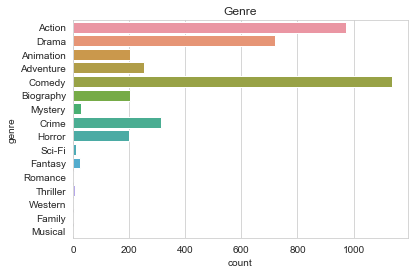

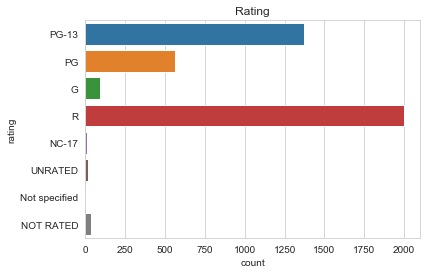

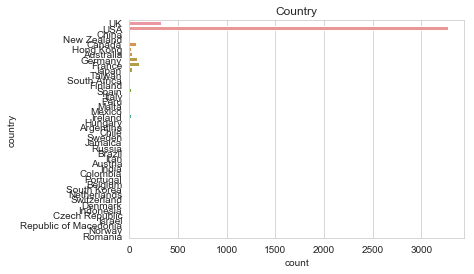

In [57]:
for col in ['genre', 'rating', 'country']:
    sns.countplot(data=df, y=col)
    plt.title(col.title())
    plt.show()

In [58]:
# Consolidate ratings
df.rating.replace(['Not specified', 'UNRATED', 'NOT RATED'],
                  'UNRATED', inplace=True)

df.rating.replace(['NC-17', 'TV-PG', 'B', 'TV-14', 'TV-MA', 'B15'],
                  'Other', inplace=True)

In [59]:
# Consolidate studio
# Number of films from each studio
studio_counts = df.studio.value_counts()

# Tiers for sparser studios
one_timers = studio_counts[studio_counts <= 1].index
five_timers = studio_counts[(studio_counts > 1) & (studio_counts <= 5)].index
ten_timers = studio_counts[(studio_counts > 5) & (studio_counts <= 10)].index
fifteen_timers = studio_counts[(studio_counts > 10) & (studio_counts <= 15)].index

# Combine sparse studios
df['studio'].replace(one_timers, 'One Timer', inplace=True)
df['studio'].replace(five_timers, 'Five Timer', inplace=True)
df['studio'].replace(ten_timers, 'Ten Timer', inplace=True)
df['studio'].replace(fifteen_timers, 'Fifteen Timer', inplace=True)

In [60]:
# Consolidate star
# Number of films from each star
star_counts = df.star.value_counts()

# Tiers for sparser stars
one_timers = star_counts[star_counts <= 1].index
three_timers = star_counts[(star_counts > 1) & (star_counts <= 3)].index
five_timers = star_counts[(star_counts > 3) & (star_counts <= 5)].index
ten_timers = star_counts[(star_counts > 5) & (star_counts <= 10)].index

# Combine sparse stars
df['star'].replace(one_timers, 'One Timer', inplace=True)
df['star'].replace(three_timers, 'Three Timer', inplace=True)
df['star'].replace(five_timers, 'Five Timer', inplace=True)
df['star'].replace(ten_timers, 'Ten Timer', inplace=True)

In [61]:
# Consolidate director
# Number of films from each director
director_counts = df.director.value_counts()

# Tiers for sparser directors
one_timers = director_counts[director_counts <= 1].index
three_timers = director_counts[(director_counts > 1) & (director_counts <= 3)].index
five_timers = director_counts[(director_counts > 3) & (director_counts <= 5)].index
ten_timers = director_counts[(director_counts > 5) & (director_counts <= 10)].index

# Combine sparse directors
df['director'].replace(one_timers, 'One Timer', inplace=True)
df['director'].replace(three_timers, 'Three Timer', inplace=True)
df['director'].replace(five_timers, 'Five Timer', inplace=True)
df['director'].replace(ten_timers, 'Ten Timer', inplace=True)

In [62]:
# Convert country to binary US / Not US
df['country_isUSA'] = (df['country'] == 'USA').astype(int)
df.head()

,budget,country,director,genre,gross,name,rating,runtime,score,star,studio,votes,profit,age,country_isUSA
0,237000000.0,UK,Five Timer,Action,760507625.0,Avatar (2009),PG-13,162,7.8,Three Timer,Twentieth Century Fox Film Corporation,958400,523507625.0,5,0
1,200000000.0,USA,Five Timer,Drama,658672302.0,Titanic (1997),PG-13,194,7.8,Leonardo DiCaprio,Twentieth Century Fox Film Corporation,865551,458672302.0,17,1
2,150000000.0,USA,Three Timer,Action,652270625.0,Jurassic World (2015),PG-13,124,7.0,Three Timer,Universal Pictures,470625,502270625.0,-1,1
3,220000000.0,USA,Three Timer,Action,623357910.0,The Avengers (2012),PG-13,143,8.1,Robert Downey Jr.,Ten Timer,1069292,403357910.0,2,1
4,185000000.0,USA,Ten Timer,Action,534858444.0,The Dark Knight (2008),PG-13,152,9.0,Christian Bale,Warner Bros.,1845853,349858444.0,6,1


In [63]:
# Consolidate genres
df.genre.replace(['Mystery', 'Sci-Fi', 'Fantasy', 'Romance', 'Thriller', 'Family', 'Western', 'Musical', 'War'],
                 'Other', inplace=True)

df.genre.unique()

array(['Action', 'Drama', 'Animation', 'Adventure', 'Comedy', 'Biography',
       'Other', 'Crime', 'Horror'], dtype=object)

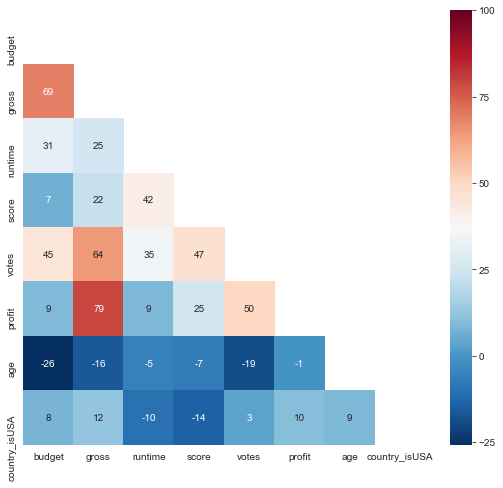

In [64]:
correlations = df.corr()

plt.figure(figsize=(9, 8));

# Create mask to hide duplicate correlations
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot heatmap
sns.set_style('whitegrid')
sns.heatmap(correlations*100, annot=True, fmt='.0f', mask=mask, cmap='RdBu_r');

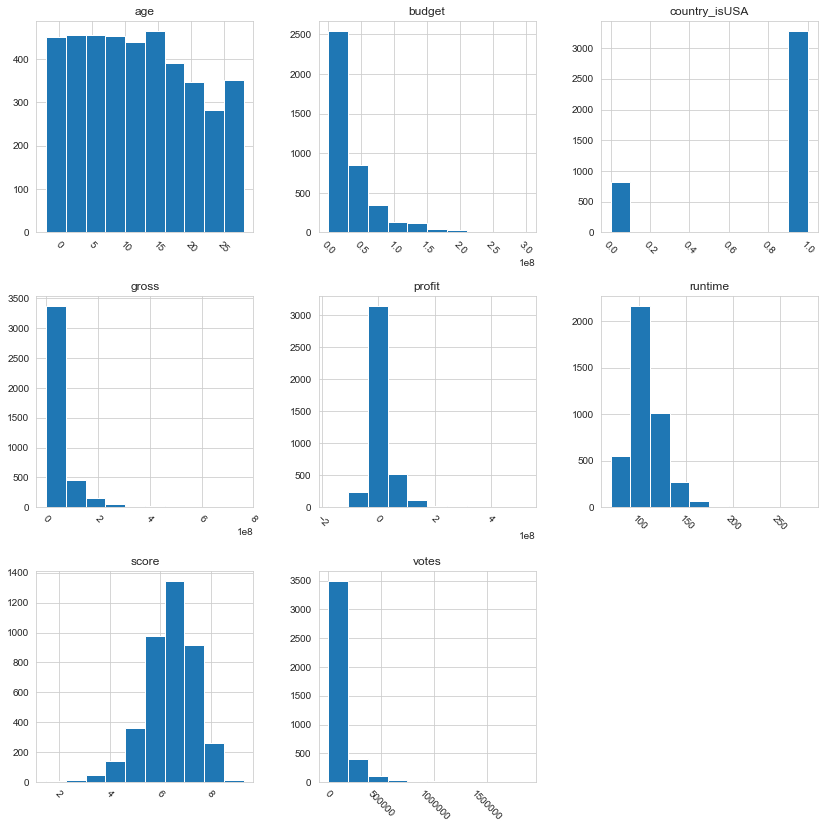

In [65]:
df.hist(figsize=(14, 14), xrot=-45);

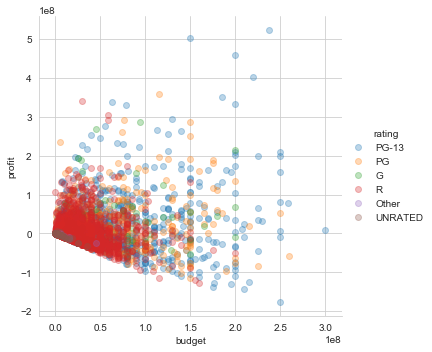

In [66]:
sns.lmplot(x='budget', y='profit', data=df, hue='rating', fit_reg=False, scatter_kws={'alpha': 0.3});

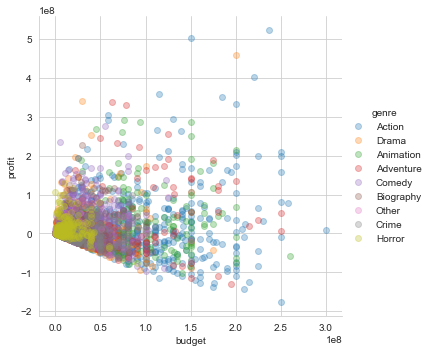

In [67]:
sns.lmplot(x='budget', y='profit', data=df, hue='genre', fit_reg=False, scatter_kws={'alpha': 0.3});

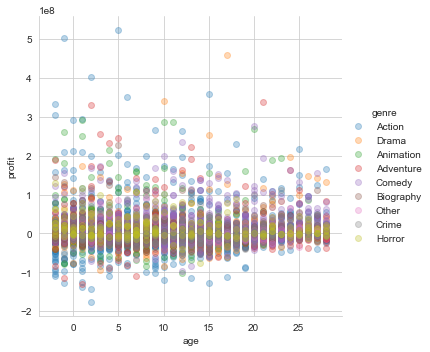

In [68]:
sns.lmplot(x='age', y='profit', data=df, hue='genre', fit_reg=False, scatter_kws={'alpha': 0.3})

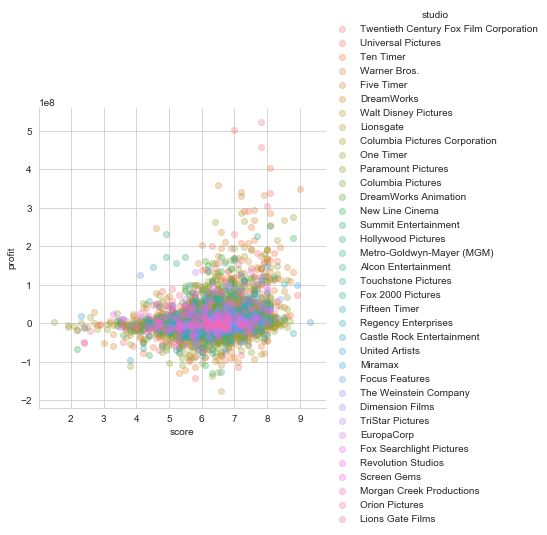

In [69]:
sns.lmplot(x='score', y='profit', data=df, hue='studio', fit_reg=False, scatter_kws={'alpha': 0.3})

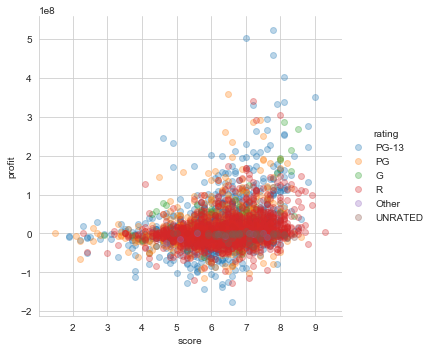

In [70]:
sns.lmplot(x='score', y='profit', data=df, hue='rating', fit_reg=False, scatter_kws={'alpha': 0.3})

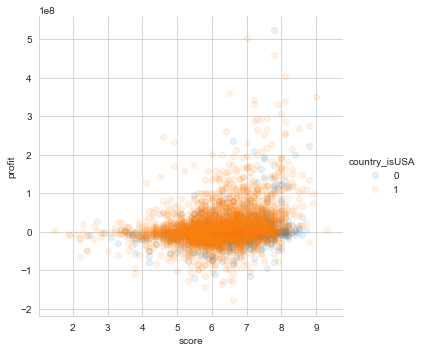

In [71]:
sns.lmplot(x='score', y='profit', data=df, hue='country_isUSA', fit_reg=False, scatter_kws={'alpha': 0.1})

In [72]:
df.head()

,budget,country,director,genre,gross,name,rating,runtime,score,star,studio,votes,profit,age,country_isUSA
0,237000000.0,UK,Five Timer,Action,760507625.0,Avatar (2009),PG-13,162,7.8,Three Timer,Twentieth Century Fox Film Corporation,958400,523507625.0,5,0
1,200000000.0,USA,Five Timer,Drama,658672302.0,Titanic (1997),PG-13,194,7.8,Leonardo DiCaprio,Twentieth Century Fox Film Corporation,865551,458672302.0,17,1
2,150000000.0,USA,Three Timer,Action,652270625.0,Jurassic World (2015),PG-13,124,7.0,Three Timer,Universal Pictures,470625,502270625.0,-1,1
3,220000000.0,USA,Three Timer,Action,623357910.0,The Avengers (2012),PG-13,143,8.1,Robert Downey Jr.,Ten Timer,1069292,403357910.0,2,1
4,185000000.0,USA,Ten Timer,Action,534858444.0,The Dark Knight (2008),PG-13,152,9.0,Christian Bale,Warner Bros.,1845853,349858444.0,6,1


In [74]:
# Create analytical base table for model
#    Drop name col and replaced country col
#    Drop cols that wouldn't be available at release (gross, votes, score - keep in one version)
#    Convert categories (director, genre, rating, star, studio) to dummy variables
#    Split train/test by age vs 2014

abt_score = df.drop(['country', 'gross', 'name', 'votes'], axis=1)
abt_score = pd.get_dummies(abt_score, columns=['director', 'genre', 'rating', 'star', 'studio'])

# Create train and test sets
x_train_wscore = abt_score[abt_score['age'] >= 0]
x_test_wscore = abt_score[abt_score['age'] < 0]
y_train = x_train_wscore['profit']
y_test = x_test_wscore['profit']

# Drop label in train and test feature set
x_train_wscore.drop('profit', axis=1, inplace=True)
x_test_wscore.drop('profit', axis=1, inplace=True)

# Drop score column for alternative feature set
x_train = x_train_wscore.drop(['score'], axis=1)
x_test = x_test_wscore.drop(['score'], axis=1)

In [75]:
x_train_wscore.head()

,budget,runtime,score,age,country_isUSA,director_Ang Lee,director_Barry Levinson,director_Brian De Palma,director_Clint Eastwood,director_Five Timer,...,studio_Summit Entertainment,studio_Ten Timer,studio_The Weinstein Company,studio_Touchstone Pictures,studio_TriStar Pictures,studio_Twentieth Century Fox Film Corporation,studio_United Artists,studio_Universal Pictures,studio_Walt Disney Pictures,studio_Warner Bros.
0,237000000.0,162,7.8,5,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,200000000.0,194,7.8,17,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,220000000.0,143,8.1,2,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,185000000.0,152,9.0,6,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,115000000.0,136,6.5,15,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
# Setup simple data processing pipelines for each model
RANDOM_STATE = 42
pipelines = {}

pipelines['enet'] = Pipeline([('scaler', StandardScaler()),
                              ('enet', ElasticNet(random_state=RANDOM_STATE))])

pipelines['rf'] = Pipeline([('scaler', StandardScaler()),
                            ('rf', RandomForestRegressor(random_state=RANDOM_STATE))])

pipelines['gb'] = Pipeline([('scaler', StandardScaler()),
                            ('gb', GradientBoostingRegressor(random_state=RANDOM_STATE))])

# Setup hyperparameter grids for each model: step_name__parameter_name
enet_hp = {'enet__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
           'enet__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}

rf_hp = {'rf__n_estimators': [100, 200],
         'rf__max_features': ['auto', 'sqrt', 0.33],
         'rf__min_samples_leaf': [1, 3, 5, 10]}

gb_hp = {'gb__n_estimators': [100, 200],
         'gb__learning_rate': [0.05, 0.1, 0.2],
         'gb__max_depth': [1, 3, 5]}

hyperparameters = {
    'enet': enet_hp,
    'rf': rf_hp,
    'gb': gb_hp
}

In [77]:
# Fit models without score feature

# Run GridSearch cross validation to fit models and tune model hyperparameters
fitted_models = {}
for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv=5, n_jobs=-1)
    model.fit(x_train, y_train)
    fitted_models[name] = model
    print(name, 'has been fitted.')

/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


enet has been fitted.


/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


rf has been fitted.
gb has been fitted.


/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


enet
Model best score: -1.4048
Mean Abs Error score on test: 36,300,079
R2 score on test: 0.0136



/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


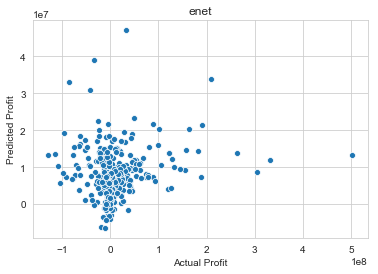

/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



rf
Model best score: -1.4064
Mean Abs Error score on test: 35,422,536
R2 score on test: 0.0513



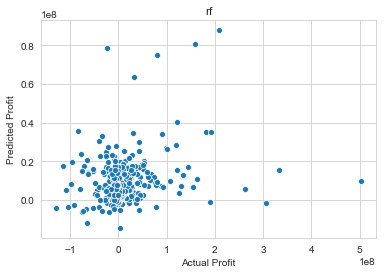


gb
Model best score: -1.6908
Mean Abs Error score on test: 36,300,146
R2 score on test: 0.0221



/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


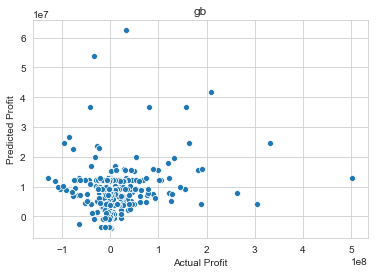

In [78]:
preds = []
for name, model in fitted_models.items():
    pred = model.predict(x_test)
    print(name)
    print('Model best score: {0:.4f}'.format(model.best_score_))
    print('Mean Abs Error score on test: {0:,.0f}'.format(mean_absolute_error(y_test, pred)))
    # print('Mean Squared Error score on test: {0:.4f}'.format(mean_squared_error(y_test, pred)))
    print('R2 score on test: {0:.4f}'.format(r2_score(y_test, pred)))
    print()
    sns.scatterplot(y_test, pred)
    plt.title(name)
    plt.xlabel('Actual Profit')
    plt.ylabel('Predicted Profit')
    plt.show()
    print()

In [79]:
# Fit models WITH score feature

# Run GridSearch cross validation to fit models and tune model hyperparameters
fitted_models_wscore = {}
for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv=5, n_jobs=-1)
    model.fit(x_train_wscore, y_train)
    fitted_models_wscore[name] = model
    print(name, 'has been fitted.')

/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


enet has been fitted.


/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


rf has been fitted.


/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


gb has been fitted.


enet
Model best score: -1.3172
Mean Abs Error score on test: 35,575,436
R2 score on test: 0.0464



/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


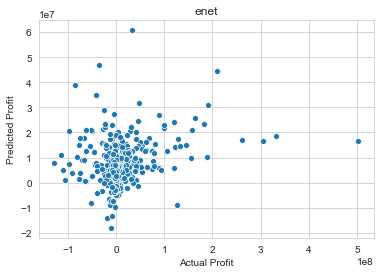

/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



rf
Model best score: -1.2269
Mean Abs Error score on test: 31,963,853
R2 score on test: 0.2075



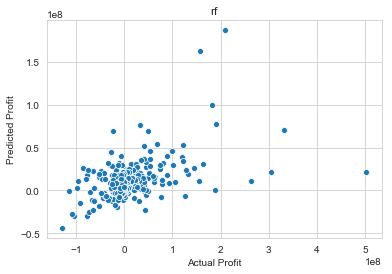


gb
Model best score: -1.4321
Mean Abs Error score on test: 32,234,546
R2 score on test: 0.2349



/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


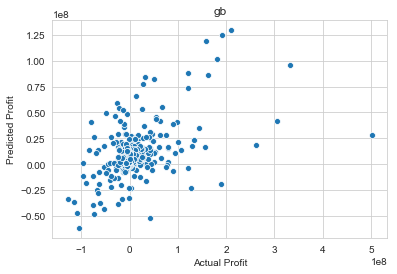

In [80]:
preds_wscore = []
for name, model in fitted_models_wscore.items():
    pred_ws = model.predict(x_test_wscore)
    print(name)
    print('Model best score: {0:.4f}'.format(model.best_score_))
    print('Mean Abs Error score on test: {0:,.0f}'.format(mean_absolute_error(y_test, pred_ws)))
    # print('Mean Squared Error score on test: {0:.4f}'.format(mean_squared_error(y_test, pred_ws)))
    print('R2 score on test: {0:.4f}'.format(r2_score(y_test, pred_ws)))
    print()
    sns.scatterplot(y_test, pred_ws)
    plt.title(name)
    plt.xlabel('Actual Profit')
    plt.ylabel('Predicted Profit')
    plt.show()
    print()

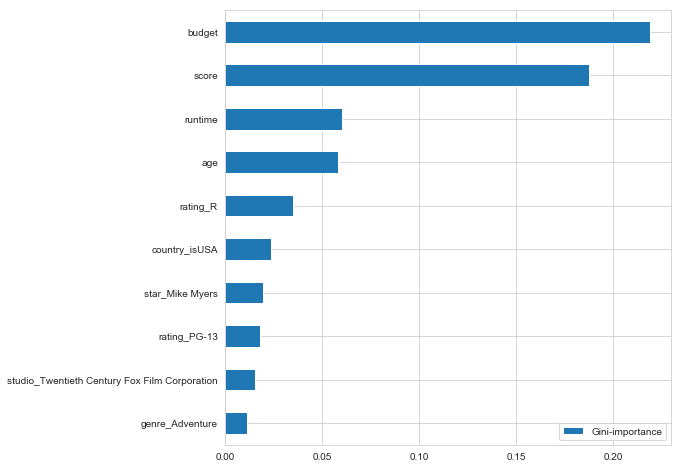

In [83]:
# View feature importances
# print(fitted_models_wscore['gb'].best_params_)

final_model = fitted_models_wscore['gb'].best_estimator_

feat_imps = final_model.steps[1][1].feature_importances_

feats = dict(zip(x_train_wscore.columns, feat_imps))
imp = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
imp.sort_values(by='Gini-importance').tail(10).plot(kind='barh', figsize=(8,8))
plt.show()

## Conclusions

As the project objectives lacked a clearly-defined "win condition", it's hard to gauge exactly how well the models performed versus expectations. Out of the three trained models - elastic net, random forest, and gradient boosting - the random forest model performed the best without `score`, and gradient boosting with it, but all had low $R^2$ scores. That said, including a proxy for `score` to train the model greatly increased all model performances, therefore effort should be taken to collect that information for predictions.

The dataset included both categorical and numeric features, with mixed levels of how they tied to the profit of a film (defined as `gross` less `budget`). Unfortunately, the strongest correlations of numeric features to `profit` were with `gross` and `votes` features, which wouldn't be available at the release of a film and therefore not usable to train the model. Also, `profit` correlated weakly with `score`, but adding that feature into the model improved the gradient boosting's $R^2$ score from $0.02$ to $0.23$, and `score` took second place for most important feature. The `budget` feature correlated strongly with `gross`, `gross` correlated strongly with `profit`, but the `budget`-`profit` correlation was weak. However, `budget` was the most important feature in the gradient boosting model, therefore showing that standalone correlation isn't always indicative of feature importance.

One funny observation was that American movies negatively correlated with `score`, so apparently the USA is churning out some bad flicks...

Looking at the categorical features, the major issue was the large number of unique values within a feature - thousands of different `stars` or `directors` in the dataset made for sparse classes. Low value counts within a feature were grouped together to reduce the feature set and help prevent overfitting. One area for improvement would be to try different approaches or thresholds to group these values to see the impact on model performance.

In general, iterating over different approaches for feature engineering and applying a wider array of algorithms could lead to better model performance in predicting movie profits.